# Section5：Transformer

# Seq2seqとは？
## 系列(Sequence)を入力として、系列を出力するもの
- Encoder-Decoderモデルとも呼ばれる 
- 入力系列がEncode(内部状態に変換)され、内部状態からDecode(系列に変換)する 
- 実応用上も、入力・出力共に系列情報なものは多い 
 - 翻訳 (英語→日本語) 
 - 音声認識 (波形→テキスト) 
 - チャットボット (テキスト→テキスト)
 


## 言語モデルとは
言語モデルは単語の並びに確率を与える

- 単語の並びに対して尤度(それがどれだけ起こり得るか)、すなわち、文章として自然かを確率で評価する 
- 例) 
 - You say goodbye → 0.092 (自然) 
 - You say good die → 0.00000032 (不自然) 
- 数式的には同時確率を事後確率に分解して表せる

### 時刻t-1までの情報で、時刻tの事後確率を求めることが目標 
→これで同時確率が計算できる

## RNN x 言語モデル

- RNNは系列情報を内部状態に変換することができる 
- 文章の各単語が現れる際の同時確率は、事後確率で分解できる 
 - したがって、事後確率を求めることがRNNの目標になる 
- 言語モデルを再現するようにRNNの重みが学習されていれば、ある時点の次の単語を予測することができる 
 - 先頭単語を与えれば文章を生成することも可能

## 実装演習

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

C:\Users\takas\anaconda3\envs\ml\lib\site-packages\wheel\pep425tags.py:80: RuntimeWarning: Config variable 'Py_DEBUG' is unset, Python ABI tag may be incorrect
  if get_flag('Py_DEBUG',
ERROR: torch-0.4.0-cp39-cp39-linux_x86_64.whl is not a supported wheel on this platform.


1.8.2+cpu
False


In [2]:
# !bitsadmin.exe /TRANSFER  https://www.dropbox.com/s/9narw5x4uizmehh/utils.py
# !mkdir images data

# # data取得
# !bitsadmin.exe /TRANSFER https://www.dropbox.com/s/o4kyc52a8we25wy/dev.en  data/
# !bitsadmin.exe /TRANSFER https://www.dropbox.com/s/kdgskm5hzg6znuc/dev.ja  data/
# !bitsadmin.exe /TRANSFER https://www.dropbox.com/s/gyyx4gohv9v65uh/test.en  data/
# !bitsadmin.exe /TRANSFER https://www.dropbox.com/s/hotxwbgoe2n013k/test.ja  data/
# !bitsadmin.exe /TRANSFER https://www.dropbox.com/s/5lsftkmb20ay9e1/train.en  data/
# !bitsadmin.exe /TRANSFER https://www.dropbox.com/s/ak53qirssci6f1j/train.ja  data/

In [3]:
! dir data

 ドライブ C のボリューム ラベルがありません。
 ボリューム シリアル番号は CAF3-F41E です

 C:\Users\takas\rabbit\rabbit-report\stage4-day2\data のディレクトリ

2021/12/27  01:38    <DIR>          .
2021/12/27  01:38    <DIR>          ..
2021/12/27  01:36            17,054 dev.en
2021/12/27  01:37            27,781 dev.ja
2021/12/27  01:37            17,301 test.en
2021/12/27  01:37            27,793 test.ja
2021/12/27  01:37         1,701,356 train.en
2021/12/27  01:38         2,784,447 train.ja
               6 個のファイル           4,575,732 バイト
               2 個のディレクトリ  344,095,592,448 バイトの空き領域


In [4]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk import bleu_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from utils import Vocab

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(1)
random_state = 42

print(torch.__version__)

1.8.2+cpu


# 1.データセットの準備
英語-日本語の対訳コーパスである、Tanaka Corpus ( http://www.edrdg.org/wiki/index.php/Tanaka_Corpus )を使います。<br>
今回はそのうちの一部分を取り出したsmall_parallel_enja: 50k En/Ja Parallel Corpus for Testing SMT Methods ( https://github.com/odashi/small_parallel_enja )を使用します。



## 1.1データの読み込みと単語の分割

In [5]:
def load_data(file_path):
    # テキストファイルからデータを読み込むメソッド
    data = []
    for line in open(file_path, encoding='utf-8'):
        words = line.strip().split()  # スペースで単語を分割
        data.append(words)
    return data

In [6]:
train_X = load_data('./data/train.en')
train_Y = load_data('./data/train.ja')

In [7]:
# 訓練データと検証データに分割
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=random_state)

この時点で入力と教師データは以下のようになっています

In [8]:
print('train data', train_X[0])
print('valid data', valid_X[0])

train data ['where', 'shall', 'we', 'eat', 'tonight', '?']
valid data ['you', 'may', 'extend', 'your', 'stay', 'in', 'tokyo', '.']


## 1.2単語辞書の作成
データセットに登場する各単語にIDを割り振る

In [9]:
# まず特殊トークンを定義しておく
PAD_TOKEN = '<PAD>'  # バッチ処理の際に、短い系列の末尾を埋めるために使う （Padding）
BOS_TOKEN = '<S>'  # 系列の始まりを表す （Beggining of sentence）
EOS_TOKEN = '</S>'  # 系列の終わりを表す （End of sentence）
UNK_TOKEN = '<UNK>'  # 語彙に存在しない単語を表す （Unknown）
PAD = 0
BOS = 1
EOS = 2
UNK = 3

In [10]:
MIN_COUNT = 2  # 語彙に含める単語の最低出現回数 再提出現回数に満たない単語はUNKに置き換えられる

# 単語をIDに変換する辞書の初期値を設定
word2id = {
    PAD_TOKEN: PAD,
    BOS_TOKEN: BOS,
    EOS_TOKEN: EOS,
    UNK_TOKEN: UNK,
    }

# 単語辞書を作成
vocab_X = Vocab(word2id=word2id)
vocab_Y = Vocab(word2id=word2id)
vocab_X.build_vocab(train_X, min_count=MIN_COUNT)
vocab_Y.build_vocab(train_Y, min_count=MIN_COUNT)

In [11]:
vocab_size_X = len(vocab_X.id2word)
vocab_size_Y = len(vocab_Y.id2word)
print('入力言語の語彙数：', vocab_size_X)
print('出力言語の語彙数：', vocab_size_Y)

入力言語の語彙数： 3725
出力言語の語彙数： 4405


# 2.テンソルへの変換
### 2.1 IDへの変換
まずはモデルが文章を認識できるように、文章を単語IDのリストに変換します

In [12]:
def sentence_to_ids(vocab, sentence):
    # 単語(str)のリストをID(int)のリストに変換する関数
    ids = [vocab.word2id.get(word, UNK) for word in sentence]
    ids += [EOS]  # EOSを加える
    return ids

In [13]:
train_X = [sentence_to_ids(vocab_X, sentence) for sentence in train_X]
train_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in train_Y]
valid_X = [sentence_to_ids(vocab_X, sentence) for sentence in valid_X]
valid_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in valid_Y]

この時点で入力と教師データは以下のようになっている

In [14]:
print('train data', train_X[0])
print('valid data', valid_X[0])

train data [132, 321, 28, 290, 367, 12, 2]
valid data [8, 93, 3532, 36, 236, 13, 284, 4, 2]


### 2.2 DataLoaderの定義
データセットからバッチを取得するデータローダーを定義します
- この際、長さの異なる複数の系列をバッチで並列に扱えるように、短い系列の末尾を特定のシンボル（`<PAD>`など）でパディングし、バッチ内の系列の長さを最長のものに合わせる
- (batch_size, max_length)のサイズの行列を得るが、実際にモデルを学習させるときには、バッチをまたいで各時刻ごとに進めていくので、転置して(max_length, batch_size)の形に変える<br>（batch_first=Trueのオプションを使う場合は不要）

In [15]:
def pad_seq(seq, max_length):
    # 系列(seq)が指定の文長(max_length)になるように末尾をパディングする
    res = seq + [PAD for i in range(max_length - len(seq))]
    return res    


class DataLoader(object):

    def __init__(self, X, Y, batch_size, shuffle=False):
        """
        :param X: list, 入力言語の文章（単語IDのリスト）のリスト
        :param Y: list, 出力言語の文章（単語IDのリスト）のリスト
        :param batch_size: int, バッチサイズ
        :param shuffle: bool, サンプルの順番をシャッフルするか否か
        """
        self.data = list(zip(X, Y))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_index = 0
        
        self.reset()
    
    def reset(self):
        if self.shuffle:  # サンプルの順番をシャッフルする
            self.data = shuffle(self.data, random_state=random_state)
        self.start_index = 0  # ポインタの位置を初期化する
    
    def __iter__(self):
        return self

    def __next__(self):
        # ポインタが最後まで到達したら初期化する
        if self.start_index >= len(self.data):
            self.reset()
            raise StopIteration()

        # バッチを取得
        seqs_X, seqs_Y = zip(*self.data[self.start_index:self.start_index+self.batch_size])
        # 入力系列seqs_Xの文章の長さ順（降順）に系列ペアをソートする
        seq_pairs = sorted(zip(seqs_X, seqs_Y), key=lambda p: len(p[0]), reverse=True)
        seqs_X, seqs_Y = zip(*seq_pairs)
        # 短い系列の末尾をパディングする
        lengths_X = [len(s) for s in seqs_X]  # 後述のEncoderのpack_padded_sequenceでも用いる
        lengths_Y = [len(s) for s in seqs_Y]
        max_length_X = max(lengths_X)
        max_length_Y = max(lengths_Y)
        padded_X = [pad_seq(s, max_length_X) for s in seqs_X]
        padded_Y = [pad_seq(s, max_length_Y) for s in seqs_Y]
        # tensorに変換し、転置する
        batch_X = torch.tensor(padded_X, dtype=torch.long, device=device).transpose(0, 1)
        batch_Y = torch.tensor(padded_Y, dtype=torch.long, device=device).transpose(0, 1)

        # ポインタを更新する
        self.start_index += self.batch_size

        return batch_X, batch_Y, lengths_X

# 3.モデルの構築
EncoderとDecoderのRNNを定義します。
### 導入：PackedSequence
PyTorchのRNNでは、可変長の系列のバッチを効率よく計算できるように系列を表現する`PackedSequence`というクラスを用いることができます。

入力バッチのテンソルをこの`PackedSequence`のインスタンスに変換してからRNNに入力することで、パディング部分の計算を省略することができるため、効率的な計算が可能になります。

`PackedSequence`を作成するには、まず、系列長の異なるバッチに対してパディングを行なってください。

ここで、パディングを行う前に各サンプルの系列長(`lengths`)を保存しておきます。

In [16]:
# 系列長がそれぞれ4,3,2の3つのサンプルからなるバッチを作成
batch = [[1,2,3,4], [5,6,7], [8,9]]
lengths = [len(sample) for sample in batch]
print('各サンプルの系列長:', lengths)
print()

# 最大系列長に合うように各サンプルをpadding
_max_length = max(lengths)
padded = torch.tensor([pad_seq(sample, _max_length) for sample in batch])
print('paddingされたテンソル:\n', padded)
padded = padded.transpose(0,1) # (max_length, batch_size)に転置
print('padding & 転置されたテンソル:\n', padded)
print('padding & 転置されたテンソルのサイズ:\n', padded.size())
print()

各サンプルの系列長: [4, 3, 2]

paddingされたテンソル:
 tensor([[1, 2, 3, 4],
        [5, 6, 7, 0],
        [8, 9, 0, 0]])
padding & 転置されたテンソル:
 tensor([[1, 5, 8],
        [2, 6, 9],
        [3, 7, 0],
        [4, 0, 0]])
padding & 転置されたテンソルのサイズ:
 torch.Size([4, 3])



次に、パディングを行ったテンソル(`padded`)と各サンプルの元々の系列長(`lengths`)を`torch.nn.utils.rnn.pack_padded_sequence`という関数に与えると、
`data`と`batch_sizes`という要素を持った`PackedSequence`のインスタンス(`packed`)が作成できます。
- `data`: テンソルの`PAD`以外の値のみを保有するベクトル
- `batch_sizes`: 各時刻で計算が必要な(=`PAD`に到達していない)バッチの数を表すベクトル

In [17]:
# PackedSequenceに変換（テンソルをRNNに入力する前に適用する）
packed = pack_padded_sequence(padded, lengths=lengths) # 各サンプルの系列長も与える
print('PackedSequenceのインスタンス:\n', packed) # テンソルのPAD以外の値(data)と各時刻で計算が必要な(=PADに到達していない)バッチの数(batch_sizes)を有するインスタンス
print()

PackedSequenceのインスタンス:
 PackedSequence(data=tensor([1, 5, 8, 2, 6, 9, 3, 7, 4]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=None, unsorted_indices=None)



こうして得られた`PackedSequence`のインスタンスをRNNに入力します。（ここでは省略）

RNNから出力されたテンソルは`PackedSeauence`のインスタンスのままなので、後段の計算につなぐために`torch.nn.utils.rnn.pad_packed_sequence`の関数によって通常のテンソルに戻します。

In [18]:
# PackedSequenceのインスタンスをRNNに入力する（ここでは省略）
output = packed

# テンソルに戻す(RNNの出力に対して適用する)
output, _length = pad_packed_sequence(output)  # PADを含む元のテンソルと各サンプルの系列長を返す
print('PADを含む元のテンソル:\n', output)
print('各サンプルの系列長:', _length)

PADを含む元のテンソル:
 tensor([[1, 5, 8],
        [2, 6, 9],
        [3, 7, 0],
        [4, 0, 0]])
各サンプルの系列長: tensor([4, 3, 2])


### Encoder
今回はEncoder側でバッチを処理する際に、`pack_padded_sequence`関数によってtensorを`PackedSequence`に変換し、処理を終えた後に`pad_packed_sequence`関数によってtensorに戻すという処理を行います。

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        :param input_size: int, 入力言語の語彙数
        :param hidden_size: int, 隠れ層のユニット数
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=PAD)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, seqs, input_lengths, hidden=None):
        """
        :param seqs: tensor, 入力のバッチ, size=(max_length, batch_size)
        :param input_lengths: 入力のバッチの各サンプルの文長
        :param hidden: tensor, 隠れ状態の初期値, Noneの場合は0で初期化される
        :return output: tensor, Encoderの出力, size=(max_length, batch_size, hidden_size)
        :return hidden: tensor, Encoderの隠れ状態, size=(1, batch_size, hidden_size)
        """
        emb = self.embedding(seqs) # seqsはパディング済み
        packed = pack_padded_sequence(emb, input_lengths) # PackedSequenceオブジェクトに変換
        output, hidden = self.gru(packed, hidden)
        output, _ = pad_packed_sequence(output)
        return output, hidden

### Decoder
今回はDecoder側ではパディング等行わないので、通常のtensorのままRNNに入力して問題ありません。

In [20]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        """
        :param hidden_size: int, 隠れ層のユニット数
        :param output_size: int, 出力言語の語彙数
        :param dropout: float, ドロップアウト率
        """
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=PAD)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, seqs, hidden):
        """
        :param seqs: tensor, 入力のバッチ, size=(1, batch_size)
        :param hidden: tensor, 隠れ状態の初期値, Noneの場合は0で初期化される
        :return output: tensor, Decoderの出力, size=(1, batch_size, output_size)
        :return hidden: tensor, Decoderの隠れ状態, size=(1, batch_size, hidden_size)
        """
        emb = self.embedding(seqs)
        output, hidden = self.gru(emb, hidden)
        output = self.out(output)
        return output, hidden

## EncoderDecoder
上で定義したEncoderとDecoderを用いた、一連の処理をまとめるEncoderDecoderのクラスを定義します。

ここで、Decoder側の処理で注意する点があります。

RNNでは、時刻$t$の出力を時刻$t+1$の入力とすることができるが、この方法でDecoderを学習させると連鎖的に誤差が大きくなっていき、学習が不安定になったり収束が遅くなったりする問題が発生します。


この問題への対策として**Teacher Forcing**というテクニックがあります。
これは、訓練時にはDecoder側の入力に、ターゲット系列（参照訳）をそのまま使うというものです。
これにより学習が安定し、収束が早くなるというメリットがありますが、逆に評価時は前の時刻にDecoderが生成したものが使われるため、学習時と分布が異なってしまうというデメリットもあります。


Teacher Forcingの拡張として、ターゲット系列を入力とするか生成された結果を入力とするかを確率的にサンプリングする**Scheduled Sampling**という手法があります。

ここではScheduled Samplingを採用し、一定の確率に基づいてターゲット系列を入力とするか生成された結果を入力とするかを切り替えられるようにクラスを定義しておきます。

In [21]:
class EncoderDecoder(nn.Module):
    """EncoderとDecoderの処理をまとめる"""
    def __init__(self, input_size, output_size, hidden_size):
        """
        :param input_size: int, 入力言語の語彙数
        :param output_size: int, 出力言語の語彙数
        :param hidden_size: int, 隠れ層のユニット数
        """
        super(EncoderDecoder, self).__init__()
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(hidden_size, output_size)

    def forward(self, batch_X, lengths_X, max_length, batch_Y=None, use_teacher_forcing=False):
        """
        :param batch_X: tensor, 入力系列のバッチ, size=(max_length, batch_size)
        :param lengths_X: list, 入力系列のバッチ内の各サンプルの文長
        :param max_length: int, Decoderの最大文長
        :param batch_Y: tensor, Decoderで用いるターゲット系列
        :param use_teacher_forcing: Decoderでターゲット系列を入力とするフラグ
        :return decoder_outputs: tensor, Decoderの出力, 
            size=(max_length, batch_size, self.decoder.output_size)
        """
        # encoderに系列を入力（複数時刻をまとめて処理）
        _, encoder_hidden = self.encoder(batch_X, lengths_X)
        
        _batch_size = batch_X.size(1)

        # decoderの入力と隠れ層の初期状態を定義
        decoder_input = torch.tensor([BOS] * _batch_size, dtype=torch.long, device=device) # 最初の入力にはBOSを使用する
        decoder_input = decoder_input.unsqueeze(0)  # (1, batch_size)
        decoder_hidden = encoder_hidden  # Encoderの最終隠れ状態を取得

        # decoderの出力のホルダーを定義
        decoder_outputs = torch.zeros(max_length, _batch_size, self.decoder.output_size, device=device) # max_length分の固定長

        # 各時刻ごとに処理
        for t in range(max_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_outputs[t] = decoder_output
            # 次の時刻のdecoderの入力を決定
            if use_teacher_forcing and batch_Y is not None:  # teacher forceの場合、ターゲット系列を用いる
                decoder_input = batch_Y[t].unsqueeze(0)
            else:  # teacher forceでない場合、自身の出力を用いる
                decoder_input = decoder_output.max(-1)[1]
                
        return decoder_outputs

# 4.訓練
### 4.1 損失関数の定義
基本的にはクロスエントロピーを損失関数として用いますが、パディングを行うと短い系列の末尾には`<PAD>`トークンが入るため、この部分の損失を計算しないように、マスクをかけます。

In [22]:
mce = nn.CrossEntropyLoss(size_average=False, ignore_index=PAD) # PADを無視する
def masked_cross_entropy(logits, target):
    logits_flat = logits.view(-1, logits.size(-1)) # (max_seq_len * batch_size, output_size)
    target_flat = target.view(-1) # (max_seq_len * batch_size, 1)
    return mce(logits_flat, target_flat)

C:\Users\takas\anaconda3\envs\ml\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### 4.2学習

In [23]:
# ハイパーパラメータの設定
num_epochs = 10
batch_size = 64
lr = 1e-3  # 学習率
teacher_forcing_rate = 0.2  # Teacher Forcingを行う確率
ckpt_path = 'model.pth'  # 学習済みのモデルを保存するパス

model_args = {
    'input_size': vocab_size_X,
    'output_size': vocab_size_Y,
    'hidden_size': 256,
}

In [24]:
# データローダを定義
train_dataloader = DataLoader(train_X, train_Y, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_X, valid_Y, batch_size=batch_size, shuffle=False)

# モデルとOptimizerを定義
model = EncoderDecoder(**model_args).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

実際に損失関数を計算する関数を定義します。

In [25]:
def compute_loss(batch_X, batch_Y, lengths_X, model, optimizer=None, is_train=True):
    # 損失を計算する関数
    model.train(is_train)  # train/evalモードの切替え
    
    # 一定確率でTeacher Forcingを行う
    use_teacher_forcing = is_train and (random.random() < teacher_forcing_rate)
    max_length = batch_Y.size(0)
    # 推論
    pred_Y = model(batch_X, lengths_X, max_length, batch_Y, use_teacher_forcing)
    
    # 損失関数を計算
    loss = masked_cross_entropy(pred_Y.contiguous(), batch_Y.contiguous())
    
    if is_train:  # 訓練時はパラメータを更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    batch_Y = batch_Y.transpose(0, 1).contiguous().data.cpu().tolist()
    pred = pred_Y.max(dim=-1)[1].data.cpu().numpy().T.tolist()

    return loss.item(), batch_Y, pred

ここで、Loss以外に、学習の進捗を確認するためにモデルの性能を評価する指標として、BLEUを計算します。

BLEUは機械翻訳の分野において最も一般的な自動評価基準の一つで、予め用意した複数の参照訳と、機械翻訳モデルが出力した訳のn-gramのマッチ率に基づく指標です。

NLTK (Natural Language Tool Kit) という自然言語処理で用いられるライブラリを用いて簡単に計算することができます。

In [26]:
def calc_bleu(refs, hyps):
    """
    BLEUスコアを計算する関数
    :param refs: list, 参照訳。単語のリストのリスト (例： [['I', 'have', 'a', 'pen'], ...])
    :param hyps: list, モデルの生成した訳。単語のリストのリスト (例： ['I', 'have', 'a', 'pen'])
    :return: float, BLEUスコア(0~100)
    """
    refs = [[ref[:ref.index(EOS)]] for ref in refs] # EOSは評価しないで良いので切り捨てる, refsのほうは複数なのでlistが一個多くかかっている
    hyps = [hyp[:hyp.index(EOS)] if EOS in hyp else hyp for hyp in hyps]
    return 100 * bleu_score.corpus_bleu(refs, hyps)

それではモデルの訓練を行います。

In [27]:
# 訓練
best_valid_bleu = 0.

for epoch in range(1, num_epochs+1):
    train_loss = 0.
    train_refs = []
    train_hyps = []
    valid_loss = 0.
    valid_refs = []
    valid_hyps = []
    # train
    for batch in train_dataloader:
        batch_X, batch_Y, lengths_X = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, lengths_X, model, optimizer, 
            is_train=True
            )
        train_loss += loss
        train_refs += gold
        train_hyps += pred
    # valid
    for batch in valid_dataloader:
        batch_X, batch_Y, lengths_X = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, lengths_X, model, 
            is_train=False
            )
        valid_loss += loss
        valid_refs += gold
        valid_hyps += pred
    # 損失をサンプル数で割って正規化
    train_loss = np.sum(train_loss) / len(train_dataloader.data)
    valid_loss = np.sum(valid_loss) / len(valid_dataloader.data)
    # BLEUを計算
    train_bleu = calc_bleu(train_refs, train_hyps)
    valid_bleu = calc_bleu(valid_refs, valid_hyps)

    # validationデータでBLEUが改善した場合にはモデルを保存
    if valid_bleu > best_valid_bleu:
        ckpt = model.to('cpu').state_dict()
        torch.save(ckpt, ckpt_path)
        best_valid_bleu = valid_bleu

    print('Epoch {}: train_loss: {:5.2f}  train_bleu: {:2.2f}  valid_loss: {:5.2f}  valid_bleu: {:2.2f}'.format(
            epoch, train_loss, train_bleu, valid_loss, valid_bleu))
        
    print('-'*80)

Epoch 1: train_loss: 52.14  train_bleu: 3.47  valid_loss: 49.35  valid_bleu: 4.60
--------------------------------------------------------------------------------
Epoch 2: train_loss: 44.78  train_bleu: 7.34  valid_loss: 44.96  valid_bleu: 7.35
--------------------------------------------------------------------------------
Epoch 3: train_loss: 40.56  train_bleu: 10.93  valid_loss: 42.49  valid_bleu: 9.54
--------------------------------------------------------------------------------
Epoch 4: train_loss: 37.79  train_bleu: 13.56  valid_loss: 41.29  valid_bleu: 12.51
--------------------------------------------------------------------------------
Epoch 5: train_loss: 35.26  train_bleu: 16.38  valid_loss: 40.34  valid_bleu: 13.75
--------------------------------------------------------------------------------
Epoch 6: train_loss: 33.46  train_bleu: 18.62  valid_loss: 40.01  valid_bleu: 14.89
--------------------------------------------------------------------------------
Epoch 7: train_

# 5.評価

In [28]:
# 学習済みモデルの読み込み
ckpt = torch.load(ckpt_path ,map_location=torch.device('cpu')) # cpuで処理する場合はmap_locationで指定する必要があります。
model.load_state_dict(ckpt)
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (embedding): Embedding(3725, 256, padding_idx=0)
    (gru): GRU(256, 256)
  )
  (decoder): Decoder(
    (embedding): Embedding(4405, 256, padding_idx=0)
    (gru): GRU(256, 256)
    (out): Linear(in_features=256, out_features=4405, bias=True)
  )
)

In [29]:
def ids_to_sentence(vocab, ids):
    # IDのリストを単語のリストに変換する
    return [vocab.id2word[_id] for _id in ids]

def trim_eos(ids):
    # IDのリストからEOS以降の単語を除外する
    if EOS in ids:
        return ids[:ids.index(EOS)]
    else:
        return ids

In [30]:
# テストデータの読み込み
test_X = load_data('./data/dev.en')
test_Y = load_data('./data/dev.ja')

In [31]:
test_X = [sentence_to_ids(vocab_X, sentence) for sentence in test_X]
test_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in test_Y]

In [32]:
test_dataloader = DataLoader(test_X, test_Y, batch_size=1, shuffle=False)

In [33]:
# 生成
batch_X, batch_Y, lengths_X = next(test_dataloader)
sentence_X = ' '.join(ids_to_sentence(vocab_X, batch_X.data.cpu().numpy()[:-1, 0]))
sentence_Y = ' '.join(ids_to_sentence(vocab_Y, batch_Y.data.cpu().numpy()[:-1, 0]))
print('src: {}'.format(sentence_X))
print('tgt: {}'.format(sentence_Y))

output = model(batch_X, lengths_X, max_length=20)
output = output.max(dim=-1)[1].view(-1).data.cpu().tolist()
output_sentence = ' '.join(ids_to_sentence(vocab_Y, trim_eos(output)))
output_sentence_without_trim = ' '.join(ids_to_sentence(vocab_Y, output))
print('out: {}'.format(output_sentence))
print('without trim: {}'.format(output_sentence_without_trim))

src: show your own business .
tgt: 自分 の 事 を しろ 。
out: 自分 の 自分 を し て て 。 。
without trim: 自分 の 自分 を し て て 。 。 </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S>


In [34]:
# BLEUの計算
test_dataloader = DataLoader(test_X, test_Y, batch_size=1, shuffle=False)
refs_list = []
hyp_list = []

for batch in test_dataloader:
    batch_X, batch_Y, lengths_X = batch
    pred_Y = model(batch_X, lengths_X, max_length=20)
    pred = pred_Y.max(dim=-1)[1].view(-1).data.cpu().tolist()
    refs = batch_Y.view(-1).data.cpu().tolist()
    refs_list.append(refs)
    hyp_list.append(pred)
bleu = calc_bleu(refs_list, hyp_list)
print(bleu)

18.6720646449301


### Beam Search
テストデータに対して新たな文を生成する際、これまでは各時刻で最も確率の高い単語を正解として採用し、次のステップでの入力として使っていました。
ただ、本当にやりたいのは、文全体の尤度が最も高くなるような文を生成することです。そのため、ただ近視眼的に確率の高い単語を採用していくより、もう少し大局的に評価していく必要があります。

Beam Searchでは、各時刻において一定の数$K$のそれまでのスコア(対数尤度など)の高い文を保持しながら選択を行っていきます。  


図はSlack上のものを参照してください。

In [35]:
class BeamEncoderDecoder(EncoderDecoder):
    """
    Beam Searchでdecodeを行うためのクラス
    """
    def __init__(self, input_size, output_size, hidden_size, beam_size=4):
        """
        :param input_size: int, 入力言語の語彙数
        :param output_size: int, 出力言語の語彙数
        :param hidden_size: int, 隠れ層のユニット数
        :param beam_size: int, ビーム数
        """
        super(BeamEncoderDecoder, self).__init__(input_size, output_size, hidden_size)
        self.beam_size = beam_size

    def forward(self, batch_X, lengths_X, max_length):
        """
        :param batch_X: tensor, 入力系列のバッチ, size=(max_length, batch_size)
        :param lengths_X: list, 入力系列のバッチ内の各サンプルの文長
        :param max_length: int, Decoderの最大文長
        :return decoder_outputs: list, 各ビームのDecoderの出力
        :return finished_scores: list of float, 各ビームのスコア
        """
        _, encoder_hidden = self.encoder(batch_X, lengths_X)

        # decoderの入力と隠れ層の初期状態を定義
        decoder_input = torch.tensor([BOS] * self.beam_size, dtype=torch.long, device=device)
        decoder_input = decoder_input.unsqueeze(0)  # (1, batch_size)
        decoder_hidden = encoder_hidden

        # beam_sizeの数だけrepeatする
        decoder_input = decoder_input.expand(1, beam_size)
        decoder_hidden = decoder_hidden.expand(1, beam_size, -1).contiguous()

        k = beam_size
        finished_beams = []
        finished_scores = []
        prev_probs = torch.zeros(beam_size, 1, dtype=torch.float, device=device)  # 前の時刻の各ビームの対数尤度を保持しておく
        output_size = self.decoder.output_size

        # 各時刻ごとに処理
        for t in range(max_length):
            # decoder_input: (1, k)
            decoder_output, decoder_hidden = self.decoder(decoder_input[-1:], decoder_hidden)
            # decoder_output: (1, k, output_size)
            # decoder_hidden: (1, k, hidden_size)
            decoder_output_t = decoder_output[-1]  # (k, output_size)
            log_probs = prev_probs + F.log_softmax(decoder_output_t, dim=-1)  # (k, output_size)
            scores = log_probs  # 対数尤度をスコアとする

            # スコアの高いビームとその単語を取得
            flat_scores = scores.view(-1)  # (k*output_size,)
            if t == 0:
                flat_scores = flat_scores[:output_size]  # t=0のときは後半の同じ値の繰り返しを除外
            top_vs, top_is = flat_scores.data.topk(k)
            beam_indices = top_is / output_size  # (k,)
            word_indices = top_is % output_size  # (k,)
            
            # ビームを更新する
            _next_beam_indices = []
            _next_word_indices = []
            for b, w in zip(beam_indices, word_indices):
                if w.item() == EOS:  # EOSに到達した場合はそのビームは更新して終了
                    k -= 1
                    beam = torch.cat([decoder_input.t()[b], w.view(1,)])  # (t+2,)
                    score = scores[b, w].item()
                    finished_beams.append(beam)
                    finished_scores.append(score)
                else:   # それ以外の場合はビームを更新
                    _next_beam_indices.append(b)
                    _next_word_indices.append(w)
            if k == 0:
                break

            # tensorｎに変換
            next_beam_indices = torch.tensor(_next_beam_indices, device=device)
            next_word_indices = torch.tensor(_next_word_indices, device=device)

            # 次の時刻のDecoderの入力を更新
            decoder_input = torch.index_select(
                decoder_input, dim=-1, index=next_beam_indices)
            decoder_input = torch.cat(
                [decoder_input, next_word_indices.unsqueeze(0)], dim=0)
    
            # 次の時刻のDecoderの隠れ層を更新
            decoder_hidden = torch.index_select(
                decoder_hidden, dim=1, index=next_beam_indices)

            # 各ビームの対数尤度を更新
            flat_probs = log_probs.view(-1)  # (k*output_size,)
            next_indices = (next_beam_indices + 1) * next_word_indices
            prev_probs = torch.index_select(
                flat_probs, dim=0, index=next_indices).unsqueeze(1)  # (k, 1)

        # すべてのビームが完了したらデータを整形
        decoder_outputs = [[idx.item() for idx in beam[1:-1]] for beam in finished_beams]
        
        return decoder_outputs, finished_scores

In [36]:
# 学習済みモデルの読み込み
beam_size = 3
beam_model = BeamEncoderDecoder(**model_args, beam_size=beam_size).to(device)
beam_model.load_state_dict(ckpt)
beam_model.eval()

BeamEncoderDecoder(
  (encoder): Encoder(
    (embedding): Embedding(3725, 256, padding_idx=0)
    (gru): GRU(256, 256)
  )
  (decoder): Decoder(
    (embedding): Embedding(4405, 256, padding_idx=0)
    (gru): GRU(256, 256)
    (out): Linear(in_features=256, out_features=4405, bias=True)
  )
)

In [37]:
test_dataloader = DataLoader(test_X, test_Y, batch_size=1, shuffle=False)

In [38]:
# 生成
batch_X, batch_Y, lengths_X = next(test_dataloader)
sentence_X = ' '.join(ids_to_sentence(vocab_X, batch_X.data.cpu().numpy()[:-1, 0]))
sentence_Y = ' '.join(ids_to_sentence(vocab_Y, batch_Y.data.cpu().numpy()[:-1, 0]))
print('src: {}'.format(sentence_X))
print('tgt: {}'.format(sentence_Y))

# 普通のdecode
output = model(batch_X, lengths_X, max_length=20)
output = output.max(dim=-1)[1].view(-1).data.cpu().tolist()
output_sentence = ' '.join(ids_to_sentence(vocab_Y, trim_eos(output)))
print('out: {}'.format(output_sentence))


src: show your own business .
tgt: 自分 の 事 を しろ 。
out: 自分 の 自分 を し て て 。 。


In [39]:
# beam decode
outputs, scores = beam_model(batch_X, lengths_X, max_length=20)

# scoreの良い順にソート
outputs, scores = zip(*sorted(zip(outputs, scores), key=lambda x: -x[1]))
for o, output in enumerate(outputs):
    output_sentence = ' '.join(ids_to_sentence(vocab_Y, output))
    print('out{}: {}'.format(o+1, output_sentence))    

RuntimeError: index_select(): Expected dtype int32 or int64 for index

# 参考文献
- [Practical PyTorch: Translation with a Sequence to Sequence Network and Attention](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb)
- [Translation with a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#sphx-glr-intermediate-seq2seq-translation-tutorial-py)
- [Encoder\-decoderモデルとTeacher Forcing，Scheduled Sampling，Professor Forcing](http://satopirka.com/2018/02/encoder-decoder%E3%83%A2%E3%83%87%E3%83%AB%E3%81%A8teacher-forcingscheduled-samplingprofessor-forcing/)
- [Sequence\-to\-Sequence Learning as Beam\-Search Optimization](https://arxiv.org/abs/1606.02960)

## ニューラル機械翻訳の問題点：長さに弱い
- 翻訳元の文の内容をひとつのベクトルで表現 
- 文長が長くなると表現力が足りなくなる 
- 文長と翻訳精度の関係性

## Attention (注意機構) 
- 翻訳先の各単語を選択する際に、翻訳元の文中の各単語の隠れ状態を利用

#### 翻訳元の各単語の隠れ状態の加重平均

\begin{aligned}
C_i = \sum_{j=1}^{T_x} \alpha_{ij}h_j
\end{aligned}

#### 重み(全て足すと１) 重みはFFNNで求める

\begin{aligned}
\alpha_{ij} &= \frac{exp(e_{ij})}{\sum_{k=1}^{T_x} exp(e_{ik})} \\[10px]
e_{ik} &= a(s_{i-1} , h_j)
\end{aligned}


### Attentionは何をしているのか
query(検索クエリ)に一致するkeyを索引し、対応するvalueを取り出す操作であると見做すことができる。これは辞書オブジェクトの機能と同じである。


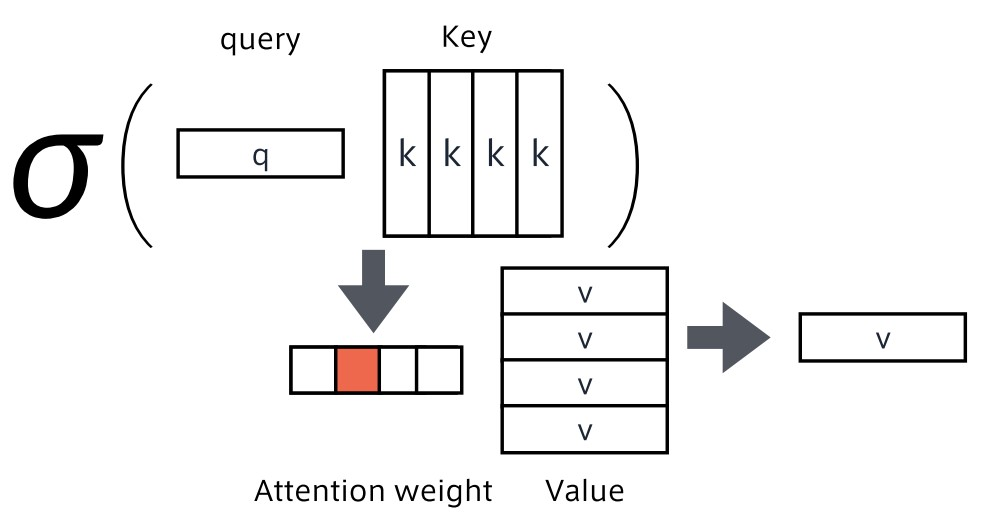

In [29]:
from IPython.display import Image
Image("./Section5_Attention1.jpg")

## Attention is all you need
- 2017年6月に登場 
- RNNを使わない 
 - 必要なのはAttentionだけ 
- 当時のSOTAをはるかに少ない計算量で実現 
 - 英仏 (3600万文) の学習を8GPUで3.5日で完了

## 注意機構には二種類ある

### Source Target-Attention(ソースターゲット注意機構)
情報が来る場所と狙う場所が分かれている。 \
受け取った情報に対して、狙うべき情報が近い場合に注目する。

### Self-Attention(自己注意機構)
Q,K,Vがすべて同じ場所から来る。

## Transformer-Encoder

### Scaled dot product attention


### Position-Wise Feed-Forward Networks
- 位置情報を保持したまま順伝播させる

### Multi-Head attention
- 全単語に関するAttentionをまとめて計算する

#### 重みパラメタの異なる８個のヘッドを使用
- ８個のScaled Dot-Product Attentionの出力をConcat 
- それぞれのヘッドが異なる種類の情報を収集

## Decoder
- Encoderと同じく6層 
 - 各層で二種類の注意機構 
 - 注意機構の仕組みはEncoderとほぼ同じ 
- 自己注意機構 
 - 生成単語列の情報を収集 
 - 直下の層の出力へのアテンション 
 - 未来の情報を見ないようにマスク 
- Encoder-Decoder attention 
 - 入力文の情報を収集 
 - Encoderの出力へのアテンション
 
### Add (Residual Connection) 
- 入出力の差分を学習させる 
- 実装上は出力に入力をそのまま加算するだけ 
- 効果：学習・テストエラーの低減 

### Norm (Layer Normalization) 
- 各層においてバイアスを除く活性化関数への入力を平均０、分散１に正則化 
- 効果：学習の高速化



## Position Encoding
RNNを用いないので単語列の語順情報を追加する必要がある

#### ゼロから作るディープラーニング②　8.1　Attentionの仕組み
これまで見てきたseq2seqをさらに強力にする注意機構（Attention mechanism）というアイデアを紹介します。このAttentionというメカニズムによって、seq2seqは私たち人間と同じように、必要な情報だけに「注意」を向けさせることができます。

# 演習 Transformerモデル
TransformerはRNNやCNNを使用せず、Attentionのみを用いるSeq2Seqモデルです。

並列計算が可能なためRNNに比べて計算が高速な上、Self-Attentionと呼ばれる機構を用いることにより、局所的な位置しか参照できないCNNと異なり、系列内の任意の位置の情報を参照することを可能にしています。

その他にもいくつかの工夫が加えられており、翻訳に限らない自然言語処理のあらゆるタスクで圧倒的な性能を示すことが知られています。

原論文：[Attention is All You Need](https://arxiv.org/abs/1706.03762)

参考実装：https://github.com/jadore801120/attention-is-all-you-need-pytorch

In [40]:
import time
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk import bleu_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils import Vocab

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(1)
random_state = 42

In [41]:
print(torch.__version__)

1.8.2+cpu


In [42]:
PAD = 0
UNK = 1
BOS = 2
EOS = 3

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
BOS_TOKEN = '<S>'
EOS_TOKEN = '</S>'

In [43]:
def load_data(file_path):
    """
    テキストファイルからデータを読み込む
    :param file_path: str, テキストファイルのパス
    :return data: list, 文章（単語のリスト）のリスト
    """
    data = []
    for line in open(file_path, encoding='utf-8'):
        words = line.strip().split()  # スペースで単語を分割
        data.append(words)
    return data

In [44]:
train_X = load_data('./data/train.en')
train_Y = load_data('./data/train.ja')

In [45]:
# 訓練データと検証データに分割
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=random_state)

In [46]:
# データセットの中身を確認
print('train_X:', train_X[:5])
print('train_Y:', train_Y[:5])

train_X: [['where', 'shall', 'we', 'eat', 'tonight', '?'], ['i', 'made', 'a', 'big', 'mistake', 'in', 'choosing', 'my', 'wife', '.'], ['i', "'ll", 'have', 'to', 'think', 'about', 'it', '.'], ['it', 'is', 'called', 'a', 'lily', '.'], ['could', 'you', 'lend', 'me', 'some', 'money', 'until', 'this', 'weekend', '?']]
train_Y: [['今夜', 'は', 'どこ', 'で', '食事', 'を', 'し', 'よ', 'う', 'か', '。'], ['僕', 'は', '妻', 'を', '選', 'ぶ', 'の', 'に', '大変', 'な', '間違い', 'を', 'し', 'た', '。'], ['考え', 'と', 'く', 'よ', '。'], ['ｌｉｌｙ', 'と', '呼', 'ば', 'れ', 'て', 'い', 'ま', 'す', '。'], ['今週末', 'まで', 'いくら', 'か', '金', 'を', '貸', 'し', 'て', 'くれ', 'ま', 'せ', 'ん', 'か', '。']]


In [47]:
MIN_COUNT = 2  # 語彙に含める単語の最低出現回数

word2id = {
    PAD_TOKEN: PAD,
    BOS_TOKEN: BOS,
    EOS_TOKEN: EOS,
    UNK_TOKEN: UNK,
    }

vocab_X = Vocab(word2id=word2id)
vocab_Y = Vocab(word2id=word2id)
vocab_X.build_vocab(train_X, min_count=MIN_COUNT)
vocab_Y.build_vocab(train_Y, min_count=MIN_COUNT)

vocab_size_X = len(vocab_X.id2word)
vocab_size_Y = len(vocab_Y.id2word)

In [48]:
def sentence_to_ids(vocab, sentence):
    """
    単語のリストをインデックスのリストに変換する
    :param vocab: Vocabのインスタンス
    :param sentence: list of str
    :return indices: list of int
    """
    ids = [vocab.word2id.get(word, UNK) for word in sentence]
    ids = [BOS] + ids + [EOS]  # EOSを末尾に加える
    return ids

In [49]:
train_X = [sentence_to_ids(vocab_X, sentence) for sentence in train_X]
train_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in train_Y]
valid_X = [sentence_to_ids(vocab_X, sentence) for sentence in valid_X]
valid_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in valid_Y]

In [50]:
class DataLoader(object):
    def __init__(self, src_insts, tgt_insts, batch_size, shuffle=True):
        """
        :param src_insts: list, 入力言語の文章（単語IDのリスト）のリスト
        :param tgt_insts: list, 出力言語の文章（単語IDのリスト）のリスト
        :param batch_size: int, バッチサイズ
        :param shuffle: bool, サンプルの順番をシャッフルするか否か
        """
        self.data = list(zip(src_insts, tgt_insts))

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_index = 0
        
        self.reset()
    
    def reset(self):
        if self.shuffle:
            self.data = shuffle(self.data, random_state=random_state)
        self.start_index = 0
    
    def __iter__(self):
        return self
    
    def __next__(self):

        def preprocess_seqs(seqs):
            # パディング
            max_length = max([len(s) for s in seqs])
            data = [s + [PAD] * (max_length - len(s)) for s in seqs]
            # 単語の位置を表現するベクトルを作成
            positions = [[pos+1 if w != PAD else 0 for pos, w in enumerate(seq)] for seq in data]
            # テンソルに変換
            data_tensor = torch.tensor(data, dtype=torch.long, device=device)
            position_tensor = torch.tensor(positions, dtype=torch.long, device=device)
            return data_tensor, position_tensor            

        # ポインタが最後まで到達したら初期化する
        if self.start_index >= len(self.data):
            self.reset()
            raise StopIteration()

        # バッチを取得して前処理
        src_seqs, tgt_seqs = zip(*self.data[self.start_index:self.start_index+self.batch_size])
        src_data, src_pos = preprocess_seqs(src_seqs)
        tgt_data, tgt_pos = preprocess_seqs(tgt_seqs)

        # ポインタを更新する
        self.start_index += self.batch_size

        return (src_data, src_pos), (tgt_data, tgt_pos)

## 2.各モジュールの定義
TransformerのモデルもEncoder-Decoderモデルの構造になっています。
EncoderとDecoderは
- Positional Encoding: 入出力の単語のEmbedding時に単語の位置情報を埋め込む
- Scaled Dot-Product Attention: 内積でAttentionを計算し、スケーリングを行う
- Multi-head Attention: Scaled Dot-Product Attentionを複数のヘッドで並列化する
- Position-Wise Feed Forward Network: 単語列の位置ごとに独立して処理を行う
など、いくつかのモジュールから構成されているため、それぞれのモジュールを個別に定義していきます。

### ① Position Encoding
Transformerは系列の処理にRNNを使用しないので、そのままでは単語列の語順を考慮することができません。

そのため、入力系列の埋め込み行列に単語の位置情報を埋め込むPosition Encodingを加算します。

Positional Encodingの行列$PE$の各成分は次式で表されます。
$PE_{(pos, 2i)} = \sin(pos/10000^{2i/d_{model}})$

$PE_{(pos, 2i+1)} = \cos(pos/10000^{2i/d_{model}})$
ここで$pos$は単語の位置を、$i$は成分の次元を表しています。

Positional Encodingの各成分は、波長が$2\pi$から$10000*2\pi$に幾何学的に伸びる正弦波に対応します。

In [51]:
def position_encoding_init(n_position, d_pos_vec):
    """
    Positional Encodingのための行列の初期化を行う
    :param n_position: int, 系列長
    :param d_pos_vec: int, 隠れ層の次元数
    :return torch.tensor, size=(n_position, d_pos_vec)
    """
    # PADがある単語の位置はpos=0にしておき、position_encも0にする
    position_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_pos_vec) for j in range(d_pos_vec)]
        if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)])
    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2])  # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2])  # dim 2i+1
    return torch.tensor(position_enc, dtype=torch.float)

ちなみに、Position Encodingを可視化すると以下のようになります。

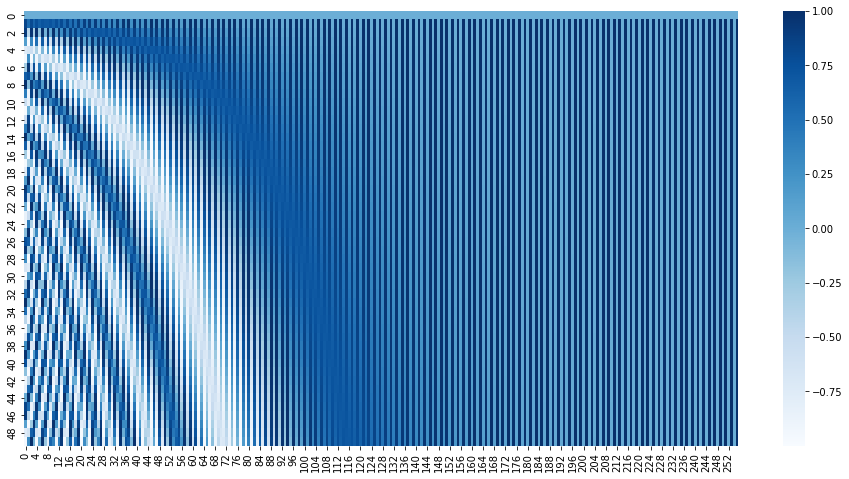

In [52]:
pe = position_encoding_init(50, 256).numpy()
plt.figure(figsize=(16,8))
sns.heatmap(pe, cmap='Blues')
plt.show()

縦軸が単語の位置を、横軸が成分の次元を表しており、濃淡が加算される値です。

ここでは最大系列長を50、隠れ層の次元数を256としました。

### ② Multihead Attention
ソース・ターゲット注意機構と自己注意機構
Attentionは一般に、queryベクトルとkeyベクトルの類似度を求めて、その正規化した重みをvalueベクトルに適用して値を取り出す処理を行います。

一般的な翻訳モデルで用いられるAttentionはソース・ターゲット注意機構と呼ばれ、この場合queryはDecoderの隠れ状態(Target)、keyはEncoderの隠れ状態(Source)、valueもEncoderの隠れ状態(Source)で表現されるのが一般的です。モデル全体の図では、右側のDecoderブロックの中央にあるAttentionがこれに相当します。

Transformerでは、このソース・ターゲット注意機構に加えて、query,key,valueを同じ系列内で定義する自己注意機構を用います。これにより、ある単語位置の出力を求める際にあらゆる位置を参照できるため、局所的な位置しか参照できない畳み込み層よりも良い性能を発揮できると言われています。モデル全体の図では、左側のEncoderブロックと右側のDecoderブロックの下部にあるAttentionがこれに当たります。

Transformerでは、Scaled Dot-Product Attentionと呼ばれるAttentionを、複数のヘッドで並列に扱うMulti-Head Attentionによって、Source-Target-AttentionとSelf-Attentionを実現します。

#### Scaled Dot-Product Attention
Attentionには、注意の重みを隠れ層 1 つのフィードフォワードネットワークで求めるAdditive Attentionと、注意の重みを内積で求めるDot-Product Attentionが存在します。  一般に、Dot-Product Attentionのほうがパラメータが少なく高速であり、Transformerでもこちらを使います。


Tranformerではさらなる工夫として、query($Q$)とkey($K$)の内積をスケーリング因子 $\sqrt{d_k}$ で除算します。

$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$ 


これは、$d_k$（keyベクトルの次元数）が大きい場合に内積が大きくなりすぎて逆伝播のsoftmaxの勾配が極端に小さくなることを防ぐ役割を果たします。

In [53]:
class ScaledDotProductAttention(nn.Module):
    
    def __init__(self, d_model, attn_dropout=0.1):
        """
        :param d_model: int, 隠れ層の次元数
        :param attn_dropout: float, ドロップアウト率
        """
        super(ScaledDotProductAttention, self).__init__()
        self.temper = np.power(d_model, 0.5)  # スケーリング因子
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, attn_mask):
        """
        :param q: torch.tensor, queryベクトル, 
            size=(n_head*batch_size, len_q, d_model/n_head)
        :param k: torch.tensor, key, 
            size=(n_head*batch_size, len_k, d_model/n_head)
        :param v: torch.tensor, valueベクトル, 
            size=(n_head*batch_size, len_v, d_model/n_head)
        :param attn_mask: torch.tensor, Attentionに適用するマスク, 
            size=(n_head*batch_size, len_q, len_k)
        :return output: 出力ベクトル, 
            size=(n_head*batch_size, len_q, d_model/n_head)
        :return attn: Attention
            size=(n_head*batch_size, len_q, len_k)
        """
        # QとKの内積でAttentionの重みを求め、スケーリングする
        attn = torch.bmm(q, k.transpose(1, 2)) / self.temper  # (n_head*batch_size, len_q, len_k)
        # Attentionをかけたくない部分がある場合は、その部分を負の無限大に飛ばしてSoftmaxの値が0になるようにする
        attn.data.masked_fill_(attn_mask, -float('inf'))
        
        attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.bmm(attn, v)

        return output, attn

#### Multi-Head Attention
TransformerではAttentionを複数のヘッドで並列に行うMulti-Head Attentionを採用しています。

複数のヘッドでAttentionを行うことにより、各ヘッドが異なる部分空間を処理でき、精度が向上するとされています。

In [54]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        """
        :param n_head: int, ヘッド数
        :param d_model: int, 隠れ層の次元数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param dropout: float, ドロップアウト率
        """
        super(MultiHeadAttention, self).__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        # 各ヘッドごとに異なる重みで線形変換を行うための重み
        # nn.Parameterを使うことで、Moduleのパラメータとして登録できる. TFでは更新が必要な変数はtf.Variableでラップするのでわかりやすい
        self.w_qs = nn.Parameter(torch.empty([n_head, d_model, d_k], dtype=torch.float))
        self.w_ks = nn.Parameter(torch.empty([n_head, d_model, d_k], dtype=torch.float))
        self.w_vs = nn.Parameter(torch.empty([n_head, d_model, d_v], dtype=torch.float))
        # nn.init.xavier_normal_で重みの値を初期化
        nn.init.xavier_normal_(self.w_qs)
        nn.init.xavier_normal_(self.w_ks)
        nn.init.xavier_normal_(self.w_vs)

        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = nn.LayerNorm(d_model) # 各層においてバイアスを除く活性化関数への入力を平均０、分散１に正則化
        self.proj = nn.Linear(n_head*d_v, d_model)  # 複数ヘッド分のAttentionの結果を元のサイズに写像するための線形層
        # nn.init.xavier_normal_で重みの値を初期化
        nn.init.xavier_normal_(self.proj.weight)
        
        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, attn_mask=None):
        """
        :param q: torch.tensor, queryベクトル, 
            size=(batch_size, len_q, d_model)
        :param k: torch.tensor, key, 
            size=(batch_size, len_k, d_model)
        :param v: torch.tensor, valueベクトル, 
            size=(batch_size, len_v, d_model)
        :param attn_mask: torch.tensor, Attentionに適用するマスク, 
            size=(batch_size, len_q, len_k)
        :return outputs: 出力ベクトル, 
            size=(batch_size, len_q, d_model)
        :return attns: Attention
            size=(n_head*batch_size, len_q, len_k)
            
        """
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        # residual connectionのための入力 出力に入力をそのまま加算する
        residual = q

        batch_size, len_q, d_model = q.size()
        batch_size, len_k, d_model = k.size()
        batch_size, len_v, d_model = v.size()

        # 複数ヘッド化
        # torch.repeat または .repeatで指定したdimに沿って同じテンソルを作成
        q_s = q.repeat(n_head, 1, 1) # (n_head*batch_size, len_q, d_model)
        k_s = k.repeat(n_head, 1, 1) # (n_head*batch_size, len_k, d_model)
        v_s = v.repeat(n_head, 1, 1) # (n_head*batch_size, len_v, d_model)
        # ヘッドごとに並列計算させるために、n_headをdim=0に、batch_sizeをdim=1に寄せる
        q_s = q_s.view(n_head, -1, d_model) # (n_head, batch_size*len_q, d_model)
        k_s = k_s.view(n_head, -1, d_model) # (n_head, batch_size*len_k, d_model)
        v_s = v_s.view(n_head, -1, d_model) # (n_head, batch_size*len_v, d_model)

        # 各ヘッドで線形変換を並列計算(p16左側`Linear`)
        q_s = torch.bmm(q_s, self.w_qs)  # (n_head, batch_size*len_q, d_k)
        k_s = torch.bmm(k_s, self.w_ks)  # (n_head, batch_size*len_k, d_k)
        v_s = torch.bmm(v_s, self.w_vs)  # (n_head, batch_size*len_v, d_v)
        # Attentionは各バッチ各ヘッドごとに計算させるためにbatch_sizeをdim=0に寄せる
        q_s = q_s.view(-1, len_q, d_k)   # (n_head*batch_size, len_q, d_k)
        k_s = k_s.view(-1, len_k, d_k)   # (n_head*batch_size, len_k, d_k)
        v_s = v_s.view(-1, len_v, d_v)   # (n_head*batch_size, len_v, d_v)

        # Attentionを計算(p16.左側`Scaled Dot-Product Attention * h`)
        outputs, attns = self.attention(q_s, k_s, v_s, attn_mask=attn_mask.repeat(n_head, 1, 1))

        # 各ヘッドの結果を連結(p16左側`Concat`)
        # torch.splitでbatch_sizeごとのn_head個のテンソルに分割
        outputs = torch.split(outputs, batch_size, dim=0)  # (batch_size, len_q, d_model) * n_head
        # dim=-1で連結
        outputs = torch.cat(outputs, dim=-1)  # (batch_size, len_q, d_model*n_head)

        # residual connectionのために元の大きさに写像(p16左側`Linear`)
        outputs = self.proj(outputs)  # (batch_size, len_q, d_model)
        outputs = self.dropout(outputs)
        outputs = self.layer_norm(outputs + residual)

        return outputs, attns

### ③ Position-Wise Feed Forward Network
単語列の位置ごとに独立して処理する2層のネットワークであるPosition-Wise Feed Forward Networkを定義します。

In [55]:
class PositionwiseFeedForward(nn.Module):
    """
    :param d_hid: int, 隠れ層1層目の次元数
    :param d_inner_hid: int, 隠れ層2層目の次元数
    :param dropout: float, ドロップアウト率
    """
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # window size 1のconv層を定義することでPosition wiseな全結合層を実現する.
        self.w_1 = nn.Conv1d(d_hid, d_inner_hid, 1)
        self.w_2 = nn.Conv1d(d_inner_hid, d_hid, 1)
        self.layer_norm = nn.LayerNorm(d_hid)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        :param x: torch.tensor,
            size=(batch_size, max_length, d_hid)
        :return: torch.tensor,
            size=(batch_size, max_length, d_hid) 
        """
        residual = x
        output = self.relu(self.w_1(x.transpose(1, 2)))
        output = self.w_2(output).transpose(2, 1)
        output = self.dropout(output)
        return self.layer_norm(output + residual)

### ④ Masking
TransformerではAttentionに対して２つのマスクを定義します。

一つはkey側の系列のPADトークンに対してAttentionを行わないようにするマスクです。

In [56]:
def get_attn_padding_mask(seq_q, seq_k):
    """
    keyのPADに対するattentionを0にするためのマスクを作成する
    :param seq_q: tensor, queryの系列, size=(batch_size, len_q)
    :param seq_k: tensor, keyの系列, size=(batch_size, len_k)
    :return pad_attn_mask: tensor, size=(batch_size, len_q, len_k)
    """
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(PAD).unsqueeze(1)   # (N, 1, len_k) PAD以外のidを全て0にする
    pad_attn_mask = pad_attn_mask.expand(batch_size, len_q, len_k) # (N, len_q, len_k)
    return pad_attn_mask

In [57]:
_seq_q = torch.tensor([[1, 2, 3]])
_seq_k = torch.tensor([[4, 5, 6, 7, PAD]])
_mask = get_attn_padding_mask(_seq_q, _seq_k)  # 行がquery、列がkeyに対応し、key側がPAD(=0)の時刻だけ1で他が0の行列ができる
print('query:\n', _seq_q)
print('key:\n', _seq_k)
print('mask:\n', _mask)

query:
 tensor([[1, 2, 3]])
key:
 tensor([[4, 5, 6, 7, 0]])
mask:
 tensor([[[False, False, False, False,  True],
         [False, False, False, False,  True],
         [False, False, False, False,  True]]])


もう一つはDecoder側でSelf Attentionを行う際に、各時刻で未来の情報に対するAttentionを行わないようにするマスクです。

In [58]:
def get_attn_subsequent_mask(seq):
    """
    未来の情報に対するattentionを0にするためのマスクを作成する
    :param seq: tensor, size=(batch_size, length)
    :return subsequent_mask: tensor, size=(batch_size, length, length)
    """
    attn_shape = (seq.size(1), seq.size(1))
    # 上三角行列(diagonal=1: 対角線より上が1で下が0)
    subsequent_mask = torch.triu(torch.ones(attn_shape, dtype=torch.uint8, device=device), diagonal=1)
    subsequent_mask = subsequent_mask.repeat(seq.size(0), 1, 1)
    return subsequent_mask

In [59]:
_seq = torch.tensor([[1,2,3,4]])
_mask = get_attn_subsequent_mask(_seq)  # 行がquery、列がkeyに対応し、queryより未来のkeyの値が1で他は0の行列ができいる
print('seq:\n', _seq)
print('mask:\n', _mask)

seq:
 tensor([[1, 2, 3, 4]])
mask:
 tensor([[[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 0]]], dtype=torch.uint8)


## 3. モデルの定義

### Encoder
これまで定義してきたサブレイヤーを統合して、Encoderを定義します。

EncoderではSelf AttentionとPosition-Wise Feed Forward Networkからなるブロックを複数層繰り返すので、ブロックのクラスEncoderLayerを定義した後にEncoderを定義します。

In [60]:
class EncoderLayer(nn.Module):
    """Encoderのブロックのクラス"""
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        """
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param dropout: float, ドロップアウト率
        """
        super(EncoderLayer, self).__init__()
        # Encoder内のSelf-Attention
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
        # Postionwise FFN
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        """
        :param enc_input: tensor, Encoderの入力, 
            size=(batch_size, max_length, d_model)
        :param slf_attn_mask: tensor, Self Attentionの行列にかけるマスク, 
            size=(batch_size, len_q, len_k)
        :return enc_output: tensor, Encoderの出力, 
            size=(batch_size, max_length, d_model)
        :return enc_slf_attn: tensor, EncoderのSelf Attentionの行列, 
            size=(n_head*batch_size, len_q, len_k)
        """
        # Self-Attentionのquery, key, valueにはすべてEncoderの入力（enc_input）が入る
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, attn_mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        return enc_output, enc_slf_attn

In [61]:
class Encoder(nn.Module):
    """EncoderLayerブロックからなるEncoderのクラス"""
    def __init__(
            self, n_src_vocab, max_length, n_layers=6, n_head=8, d_k=64, d_v=64,
            d_word_vec=512, d_model=512, d_inner_hid=1024, dropout=0.1):
        """
        :param n_src_vocab: int, 入力言語の語彙数
        :param max_length: int, 最大系列長
        :param n_layers: int, レイヤー数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param d_word_vec: int, 単語の埋め込みの次元数
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param dropout: float, ドロップアウト率        
        """
        super(Encoder, self).__init__()

        n_position = max_length + 1
        self.max_length = max_length
        self.d_model = d_model

        # Positional Encodingを用いたEmbedding
        self.position_enc = nn.Embedding(n_position, d_word_vec, padding_idx=PAD)
        self.position_enc.weight.data = position_encoding_init(n_position, d_word_vec)

        # 一般的なEmbedding
        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=PAD)

        # EncoderLayerをn_layers個積み重ねる
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])

    def forward(self, src_seq, src_pos):
        """
        :param src_seq: tensor, 入力系列, 
            size=(batch_size, max_length)
        :param src_pos: tensor, 入力系列の各単語の位置情報,
            size=(batch_size, max_length)
        :return enc_output: tensor, Encoderの最終出力, 
            size=(batch_size, max_length, d_model)
        :return enc_slf_attns: list, EncoderのSelf Attentionの行列のリスト
        """
        # 一般的な単語のEmbeddingを行う
        enc_input = self.src_word_emb(src_seq)
        # Positional EncodingのEmbeddingを加算する
        enc_input += self.position_enc(src_pos)

        enc_slf_attns = []
        enc_output = enc_input
        # key(=enc_input)のPADに対応する部分のみ1のマスクを作成
        enc_slf_attn_mask = get_attn_padding_mask(src_seq, src_seq)

        # n_layers個のEncoderLayerに入力を通す
        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(
                enc_output, slf_attn_mask=enc_slf_attn_mask)
            enc_slf_attns += [enc_slf_attn]

        return enc_output, enc_slf_attns

### Decoder

Deocoderも同様にSelf Attention, Source-Target Attention, Position-Wise Feed Forward Networkからなるブロックを複数層繰り返ので、ブロックのクラスDecoderLayerを定義した後にDecoderを定義します。

In [62]:
class DecoderLayer(nn.Module):
    """Decoderのブロックのクラス"""
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        """
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param dropout: float, ドロップアウト率
        """
        super(DecoderLayer, self).__init__()
        # Decoder内のSelf-Attention
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        # Encoder-Decoder間のSource-Target Attention
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        # Positionwise FFN
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)

    def forward(self, dec_input, enc_output, slf_attn_mask=None, dec_enc_attn_mask=None):
        """
        :param dec_input: tensor, Decoderの入力, 
            size=(batch_size, max_length, d_model)
        :param enc_output: tensor, Encoderの出力, 
            size=(batch_size, max_length, d_model)
        :param slf_attn_mask: tensor, Self Attentionの行列にかけるマスク, 
            size=(batch_size, len_q, len_k)
        :param dec_enc_attn_mask: tensor, Soutce-Target Attentionの行列にかけるマスク, 
            size=(batch_size, len_q, len_k)
        :return dec_output: tensor, Decoderの出力, 
            size=(batch_size, max_length, d_model)
        :return dec_slf_attn: tensor, DecoderのSelf Attentionの行列, 
            size=(n_head*batch_size, len_q, len_k)
        :return dec_enc_attn: tensor, DecoderのSoutce-Target Attentionの行列, 
            size=(n_head*batch_size, len_q, len_k)
        """
        # Self-Attentionのquery, key, valueにはすべてDecoderの入力（dec_input）が入る
        dec_output, dec_slf_attn = self.slf_attn(
            dec_input, dec_input, dec_input, attn_mask=slf_attn_mask)
        # Source-Target-AttentionのqueryにはDecoderの出力(dec_output), key, valueにはEncoderの出力（enc_output）が入る
        dec_output, dec_enc_attn = self.enc_attn(
            dec_output, enc_output, enc_output, attn_mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)

        return dec_output, dec_slf_attn, dec_enc_attn

In [63]:
class Decoder(nn.Module):
    """DecoderLayerブロックからなるDecoderのクラス"""
    def __init__(
            self, n_tgt_vocab, max_length, n_layers=6, n_head=8, d_k=64, d_v=64,
            d_word_vec=512, d_model=512, d_inner_hid=1024, dropout=0.1):
        """
        :param n_tgt_vocab: int, 出力言語の語彙数
        :param max_length: int, 最大系列長
        :param n_layers: int, レイヤー数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param d_word_vec: int, 単語の埋め込みの次元数
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param dropout: float, ドロップアウト率        
        """
        super(Decoder, self).__init__()
        n_position = max_length + 1
        self.max_length = max_length
        self.d_model = d_model

        # Positional Encodingを用いたEmbedding
        self.position_enc = nn.Embedding(
            n_position, d_word_vec, padding_idx=PAD)
        self.position_enc.weight.data = position_encoding_init(n_position, d_word_vec)

        # 一般的なEmbedding
        self.tgt_word_emb = nn.Embedding(
            n_tgt_vocab, d_word_vec, padding_idx=PAD)
        self.dropout = nn.Dropout(dropout)

        # DecoderLayerをn_layers個積み重ねる
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])

    def forward(self, tgt_seq, tgt_pos, src_seq, enc_output):
        """
        :param tgt_seq: tensor, 出力系列, 
            size=(batch_size, max_length)
        :param tgt_pos: tensor, 出力系列の各単語の位置情報,
            size=(batch_size, max_length)
        :param src_seq: tensor, 入力系列, 
            size=(batch_size, n_src_vocab)
        :param enc_output: tensor, Encoderの出力, 
            size=(batch_size, max_length, d_model)
        :return dec_output: tensor, Decoderの最終出力, 
            size=(batch_size, max_length, d_model)
        :return dec_slf_attns: list, DecoderのSelf Attentionの行列のリスト 
        :return dec_slf_attns: list, DecoderのSelf Attentionの行列のリスト
        """
        # 一般的な単語のEmbeddingを行う
        dec_input = self.tgt_word_emb(tgt_seq)
        # Positional EncodingのEmbeddingを加算する
        dec_input += self.position_enc(tgt_pos)

        # Self-Attention用のマスクを作成
        # key(=dec_input)のPADに対応する部分が1のマスクと、queryから見たkeyの未来の情報に対応する部分が1のマスクのORをとる
        dec_slf_attn_pad_mask = get_attn_padding_mask(tgt_seq, tgt_seq)  # (N, max_length, max_length)
        dec_slf_attn_sub_mask = get_attn_subsequent_mask(tgt_seq)  # (N, max_length, max_length)
        dec_slf_attn_mask = torch.gt(dec_slf_attn_pad_mask + dec_slf_attn_sub_mask, 0)  # ORをとる

        # key(=dec_input)のPADに対応する部分のみ1のマスクを作成
        dec_enc_attn_pad_mask = get_attn_padding_mask(tgt_seq, src_seq)  # (N, max_length, max_length)

        dec_slf_attns, dec_enc_attns = [], []

        dec_output = dec_input
        # n_layers個のDecoderLayerに入力を通す
        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output, enc_output,
                slf_attn_mask=dec_slf_attn_mask,
                dec_enc_attn_mask=dec_enc_attn_pad_mask)

            dec_slf_attns += [dec_slf_attn]
            dec_enc_attns += [dec_enc_attn]

        return dec_output, dec_slf_attns, dec_enc_attns

In [64]:
class Transformer(nn.Module):
    """Transformerのモデル全体のクラス"""
    def __init__(
            self, n_src_vocab, n_tgt_vocab, max_length, n_layers=6, n_head=8,
            d_word_vec=512, d_model=512, d_inner_hid=1024, d_k=64, d_v=64,
            dropout=0.1, proj_share_weight=True):
        """
        :param n_src_vocab: int, 入力言語の語彙数
        :param n_tgt_vocab: int, 出力言語の語彙数
        :param max_length: int, 最大系列長
        :param n_layers: int, レイヤー数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param d_word_vec: int, 単語の埋め込みの次元数
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param dropout: float, ドロップアウト率        
        :param proj_share_weight: bool, 出力言語の単語のEmbeddingと出力の写像で重みを共有する        
        """
        super(Transformer, self).__init__()
        self.encoder = Encoder(
            n_src_vocab, max_length, n_layers=n_layers, n_head=n_head,
            d_word_vec=d_word_vec, d_model=d_model,
            d_inner_hid=d_inner_hid, dropout=dropout)
        self.decoder = Decoder(
            n_tgt_vocab, max_length, n_layers=n_layers, n_head=n_head,
            d_word_vec=d_word_vec, d_model=d_model,
            d_inner_hid=d_inner_hid, dropout=dropout)
        self.tgt_word_proj = nn.Linear(d_model, n_tgt_vocab, bias=False)
        nn.init.xavier_normal_(self.tgt_word_proj.weight)
        self.dropout = nn.Dropout(dropout)

        assert d_model == d_word_vec  # 各モジュールの出力のサイズは揃える

        if proj_share_weight:
            # 出力言語の単語のEmbeddingと出力の写像で重みを共有する
            assert d_model == d_word_vec
            self.tgt_word_proj.weight = self.decoder.tgt_word_emb.weight

    def get_trainable_parameters(self):
        # Positional Encoding以外のパラメータを更新する
        enc_freezed_param_ids = set(map(id, self.encoder.position_enc.parameters()))
        dec_freezed_param_ids = set(map(id, self.decoder.position_enc.parameters()))
        freezed_param_ids = enc_freezed_param_ids | dec_freezed_param_ids
        return (p for p in self.parameters() if id(p) not in freezed_param_ids)

    def forward(self, src, tgt):
        src_seq, src_pos = src
        tgt_seq, tgt_pos = tgt

        src_seq = src_seq[:, 1:]
        src_pos = src_pos[:, 1:]
        tgt_seq = tgt_seq[:, :-1]
        tgt_pos = tgt_pos[:, :-1]

        enc_output, *_ = self.encoder(src_seq, src_pos)
        dec_output, *_ = self.decoder(tgt_seq, tgt_pos, src_seq, enc_output)
        seq_logit = self.tgt_word_proj(dec_output)

        return seq_logit

## 4. 学習

In [65]:
def compute_loss(batch_X, batch_Y, model, criterion, optimizer=None, is_train=True):
    # バッチの損失を計算
    model.train(is_train)
    
    pred_Y = model(batch_X, batch_Y)
    gold = batch_Y[0][:, 1:].contiguous()
#     gold = batch_Y[0].contiguous()
    loss = criterion(pred_Y.view(-1, pred_Y.size(2)), gold.view(-1))

    if is_train:  # 訓練時はパラメータを更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    gold = gold.data.cpu().numpy().tolist()
    pred = pred_Y.max(dim=-1)[1].data.cpu().numpy().tolist()

    return loss.item(), gold, pred

In [66]:
MAX_LENGTH = 20
batch_size = 64
num_epochs = 15
lr = 0.001
ckpt_path = 'transformer.pth'
max_length = MAX_LENGTH + 2

In [67]:
model_args = {
    'n_src_vocab': vocab_size_X,
    'n_tgt_vocab': vocab_size_Y,
    'max_length': max_length,
    'proj_share_weight': True,
    'd_k': 32,
    'd_v': 32,
    'd_model': 128,
    'd_word_vec': 128,
    'd_inner_hid': 256,
    'n_layers': 3,
    'n_head': 6,
    'dropout': 0.1,
}

In [68]:
# DataLoaderやモデルを定義
train_dataloader = DataLoader(
    train_X, train_Y, batch_size
    )
valid_dataloader = DataLoader(
    valid_X, valid_Y, batch_size, 
    shuffle=False
    )

model = Transformer(**model_args).to(device)

optimizer = optim.Adam(model.get_trainable_parameters(), lr=lr)

criterion = nn.CrossEntropyLoss(ignore_index=PAD, size_average=False).to(device)

C:\Users\takas\anaconda3\envs\ml\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [69]:
def calc_bleu(refs, hyps):
    """
    BLEUスコアを計算する関数
    :param refs: list, 参照訳。単語のリストのリスト (例： [['I', 'have', 'a', 'pen'], ...])
    :param hyps: list, モデルの生成した訳。単語のリストのリスト (例： [['I', 'have', 'a', 'pen'], ...])
    :return: float, BLEUスコア(0~100)
    """
    refs = [[ref[:ref.index(EOS)]] for ref in refs]
    hyps = [hyp[:hyp.index(EOS)] if EOS in hyp else hyp for hyp in hyps]
    return 100 * bleu_score.corpus_bleu(refs, hyps)

In [70]:
# 訓練
best_valid_bleu = 0.

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss = 0.
    train_refs = []
    train_hyps = []
    valid_loss = 0.
    valid_refs = []
    valid_hyps = []
    # train
    for batch in train_dataloader:
        batch_X, batch_Y = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, model, criterion, optimizer, is_train=True
            )
        train_loss += loss
        train_refs += gold
        train_hyps += pred
    # valid
    for batch in valid_dataloader:
        batch_X, batch_Y = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, model, criterion, is_train=False
            )
        valid_loss += loss
        valid_refs += gold
        valid_hyps += pred
    # 損失をサンプル数で割って正規化
    train_loss /= len(train_dataloader.data) 
    valid_loss /= len(valid_dataloader.data) 
    # BLEUを計算
    train_bleu = calc_bleu(train_refs, train_hyps)
    valid_bleu = calc_bleu(valid_refs, valid_hyps)

    # validationデータでBLEUが改善した場合にはモデルを保存
    if valid_bleu > best_valid_bleu:
        ckpt = model.to('cpu').state_dict()
        torch.save(ckpt, ckpt_path)
        best_valid_bleu = valid_bleu

    elapsed_time = (time.time()-start) / 60
    print('Epoch {} [{:.1f}min]: train_loss: {:5.2f}  train_bleu: {:2.2f}  valid_loss: {:5.2f}  valid_bleu: {:2.2f}'.format(
            epoch, elapsed_time, train_loss, train_bleu, valid_loss, valid_bleu))
    print('-'*80)

Epoch 1 [3.3min]: train_loss: 77.49  train_bleu: 4.61  valid_loss: 41.30  valid_bleu: 10.62
--------------------------------------------------------------------------------
Epoch 2 [3.3min]: train_loss: 39.31  train_bleu: 12.33  valid_loss: 32.10  valid_bleu: 17.69
--------------------------------------------------------------------------------
Epoch 3 [3.3min]: train_loss: 31.82  train_bleu: 18.13  valid_loss: 28.00  valid_bleu: 22.11
--------------------------------------------------------------------------------
Epoch 4 [3.3min]: train_loss: 28.15  train_bleu: 21.78  valid_loss: 25.68  valid_bleu: 24.99
--------------------------------------------------------------------------------
Epoch 5 [3.3min]: train_loss: 25.71  train_bleu: 24.50  valid_loss: 24.28  valid_bleu: 26.83
--------------------------------------------------------------------------------
Epoch 6 [3.3min]: train_loss: 23.88  train_bleu: 26.84  valid_loss: 22.91  valid_bleu: 29.09
--------------------------------------

## 5. 評価

In [71]:
def test(model, src, max_length=20):
    # 学習済みモデルで系列を生成する
    model.eval()
    
    src_seq, src_pos = src
    batch_size = src_seq.size(0)
    enc_output, enc_slf_attns = model.encoder(src_seq, src_pos)
        
    tgt_seq = torch.full([batch_size, 1], BOS, dtype=torch.long, device=device)
    tgt_pos = torch.arange(1, dtype=torch.long, device=device)
    tgt_pos = tgt_pos.unsqueeze(0).repeat(batch_size, 1)

    # 時刻ごとに処理
    for t in range(1, max_length+1):
        dec_output, dec_slf_attns, dec_enc_attns = model.decoder(
            tgt_seq, tgt_pos, src_seq, enc_output)
        dec_output = model.tgt_word_proj(dec_output)
        out = dec_output[:, -1, :].max(dim=-1)[1].unsqueeze(1)
        # 自身の出力を次の時刻の入力にする
        tgt_seq = torch.cat([tgt_seq, out], dim=-1)
        tgt_pos = torch.arange(t+1, dtype=torch.long, device=device)
        tgt_pos = tgt_pos.unsqueeze(0).repeat(batch_size, 1)

    return tgt_seq[:, 1:], enc_slf_attns, dec_slf_attns, dec_enc_attns

In [72]:
def ids_to_sentence(vocab, ids):
    # IDのリストを単語のリストに変換する
    return [vocab.id2word[_id] for _id in ids]

def trim_eos(ids):
    # IDのリストからEOS以降の単語を除外する
    if EOS in ids:
        return ids[:ids.index(EOS)]
    else:
        return ids

In [73]:
# 学習済みモデルの読み込み
model = Transformer(**model_args).to(device)
ckpt = torch.load(ckpt_path , map_location=torch.device('cpu'))
model.load_state_dict(ckpt)

<All keys matched successfully>

In [74]:
# テストデータの読み込み
test_X = load_data('./data/dev.en')
test_Y = load_data('./data/dev.ja')
test_X = [sentence_to_ids(vocab_X, sentence) for sentence in test_X]
test_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in test_Y]

### 生成

In [75]:
test_dataloader = DataLoader(
    test_X, test_Y, 1,
    shuffle=False
    )

In [76]:
src, tgt = next(test_dataloader)

src_ids = src[0][0].cpu().numpy()
tgt_ids = tgt[0][0].cpu().numpy()

print('src: {}'.format(' '.join(ids_to_sentence(vocab_X, src_ids[1:-1]))))
print('tgt: {}'.format(' '.join(ids_to_sentence(vocab_Y, tgt_ids[1:-1]))))

preds, enc_slf_attns, dec_slf_attns, dec_enc_attns = test(model, src)
pred_ids = preds[0].data.cpu().numpy().tolist()
print('out: {}'.format(' '.join(ids_to_sentence(vocab_Y, trim_eos(pred_ids)))))

src: show your own business .
tgt: 自分 の 事 を しろ 。
out: あなた の 顔 を <UNK> し て い た い 。


## BLEUの評価

In [77]:
# BLEUの評価
test_dataloader = DataLoader(
    test_X, test_Y, 128,
    shuffle=False
    )
refs_list = []
hyp_list = []

for batch in test_dataloader:
    batch_X, batch_Y = batch
    preds, *_ = test(model, batch_X)
    preds = preds.data.cpu().numpy().tolist()
    refs = batch_Y[0].data.cpu().numpy()[:, 1:].tolist()
    refs_list += refs
    hyp_list += preds
bleu = calc_bleu(refs_list, hyp_list)
print(bleu)

24.603488346979837
